# Netflix Movie Recommendation System
## Predicting User Movie Preferences

### Problem Statement
Netflix wants to improve its recommendation engine by predicting whether a user will like a movie or TV show based on their viewing history, demographics, and movie/series metadata (genre, cast, ratings, release year).

### Project Objective
Perform an end-to-end ML workflow to build a predictive model that can:
- Predict user preferences with high accuracy
- Handle both content-based and collaborative filtering approaches
- Provide insights for improving Netflix's recommendation system

### Deliverables
1. Preprocessed dataset with user and movie features
2. At least 3 trained models with documented preprocessing pipelines
3. Comparison report of performance metrics
4. Final recommendation for improving Netflix's recommendation system

## 1. Import Required Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn

# XGBoost
import xgboost as xgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries loaded")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

All libraries loaded
Pandas version: 2.3.2
NumPy version: 2.3.3
Scikit-learn version: 1.7.2


In [2]:
# Load the Netflix dataset
df_movies = pd.read_csv('netflix_movies_detailed_up_to_2025.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df_movies.shape}")
print(f"Memory usage: {df_movies.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df_movies.info())

print("\n" + "="*50)
print("FIRST FEW ROWS")
print("="*50)
print(df_movies.head())

Dataset loaded successfully!
Dataset shape: (16000, 18)
Memory usage: 15.56 MB

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       16000 non-null  int64  
 1   type          16000 non-null  object 
 2   title         16000 non-null  object 
 3   director      15868 non-null  object 
 4   cast          15796 non-null  object 
 5   country       15534 non-null  object 
 6   date_added    16000 non-null  object 
 7   release_year  16000 non-null  int64  
 8   rating        16000 non-null  float64
 9   duration      0 non-null      float64
 10  genres        15893 non-null  object 
 11  language      16000 non-null  object 
 12  description   15868 non-null  object 
 13  popularity    16000 non-null  float64
 14  vote_count    16000 non-null  int64  
 15  vote_average  16000 non-null  float64
 16  budget        1

## 2. Load User and Interaction Data

Loading the pre-generated user profiles and user-movie interaction data from CSV files.

In [7]:
# Load user and interaction data from CSV files
print("Loading user and interaction data from saved CSV files...")

# Load user data
df_users = pd.read_csv('netflix_user.csv')
print(f"✓ Loaded user data: {len(df_users)} users")

# Load user-movie interactions
df_interactions = pd.read_csv('netflix_user_movie_interaction.csv')
print(f"✓ Loaded user interactions: {len(df_interactions)} interactions")

# Convert interaction_date back to datetime if needed
df_interactions['interaction_date'] = pd.to_datetime(df_interactions['interaction_date'])

print(f"\nData Summary:")
print(f"- Users: {len(df_users)}")
print(f"- Movies in dataset: {len(df_movies)}")
print(f"- User-movie interactions: {len(df_interactions)}")
print(f"- Unique users with interactions: {df_interactions['user_id'].nunique()}")
print(f"- Unique movies with interactions: {df_interactions['show_id'].nunique()}")
print(f"- Like ratio: {df_interactions['liked'].mean():.3f}")

print(f"\nRating distribution:")
print(f"- Liked movies: Mean={df_interactions[df_interactions['liked']==1]['rating'].mean():.2f}")
print(f"- Disliked movies: Mean={df_interactions[df_interactions['liked']==0]['rating'].mean():.2f}")

print("\nUser data sample:")
print(df_users.head())

print("\nInteraction data sample:")
print(df_interactions.head())

Loading user and interaction data from saved CSV files...
✓ Loaded user data: 5000 users
✓ Loaded user interactions: 49988 interactions

Data Summary:
- Users: 5000
- Movies in dataset: 16000
- User-movie interactions: 49988
- Unique users with interactions: 4999
- Unique movies with interactions: 15291
- Like ratio: 0.505

Rating distribution:
- Liked movies: Mean=7.20
- Disliked movies: Mean=4.87

User data sample:
   user_id  age gender country subscription_type           preferred_genres  \
0        1   40   Male      UK          Standard            Comedy,Thriller   
1        2   33   Male     USA          Standard          Animation,Fantasy   
2        3   42   Male  Brazil          Standard            Animation,Drama   
3        4   53   Male      UK          Standard                     Comedy   
4        5   32   Male      UK             Basic  Action,Documentary,Horror   

   avg_daily_watch_time preferred_watch_time  account_age_months  
0                  8.00              

## 3. Exploratory Data Analysis

In [5]:
# Explore movie dataset
print("Movie Dataset Overview")
print("-" * 20)

# Missing values analysis
print("\nMissing values in movie dataset:")
missing_values = df_movies.isnull().sum()
missing_percentage = (missing_values / len(df_movies)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

# Data types and unique values
print("\nData types and unique values:")
for col in df_movies.columns:
    if df_movies[col].dtype == 'object':
        unique_count = df_movies[col].nunique()
        print(f"{col}: {df_movies[col].dtype}, {unique_count} unique values")
        if unique_count <= 10:
            print(f"  Values: {df_movies[col].unique()}")
    else:
        print(f"{col}: {df_movies[col].dtype}, Range: {df_movies[col].min():.2f} - {df_movies[col].max():.2f}")

# Analyze genres
print("\n" + "="*50)
print("\nGenre Breakdown")

# Extract all genres
all_genres = []
for genres in df_movies['genres'].dropna():
    genre_list = [g.strip() for g in str(genres).split(',')]
    all_genres.extend(genre_list)

# Count genre frequency
from collections import Counter
genre_counts = Counter(all_genres)
print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 10 most common genres:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count} movies ({count/len(df_movies)*100:.1f}%)")

Movie Dataset Overview
--------------------

Missing values in movie dataset:
             Missing Count  Percentage
duration             16000   100.00000
country                466     2.91250
cast                   204     1.27500
director               132     0.82500
description            132     0.82500
genres                 107     0.66875

Data types and unique values:
show_id: int64, Range: 189.00 - 1440471.00
type: object, 1 unique values
  Values: ['Movie']
title: object, 15485 unique values
director: object, 9508 unique values
cast: object, 15639 unique values
country: object, 1463 unique values
date_added: object, 4423 unique values
release_year: int64, Range: 2010.00 - 2025.00
rating: float64, Range: 0.00 - 10.00
duration: float64, Range: nan - nan
genres: object, 2768 unique values
language: object, 74 unique values
description: object, 15854 unique values
popularity: float64, Range: 3.86 - 3876.01
vote_count: int64, Range: 0.00 - 37119.00
vote_average: float64, Range:

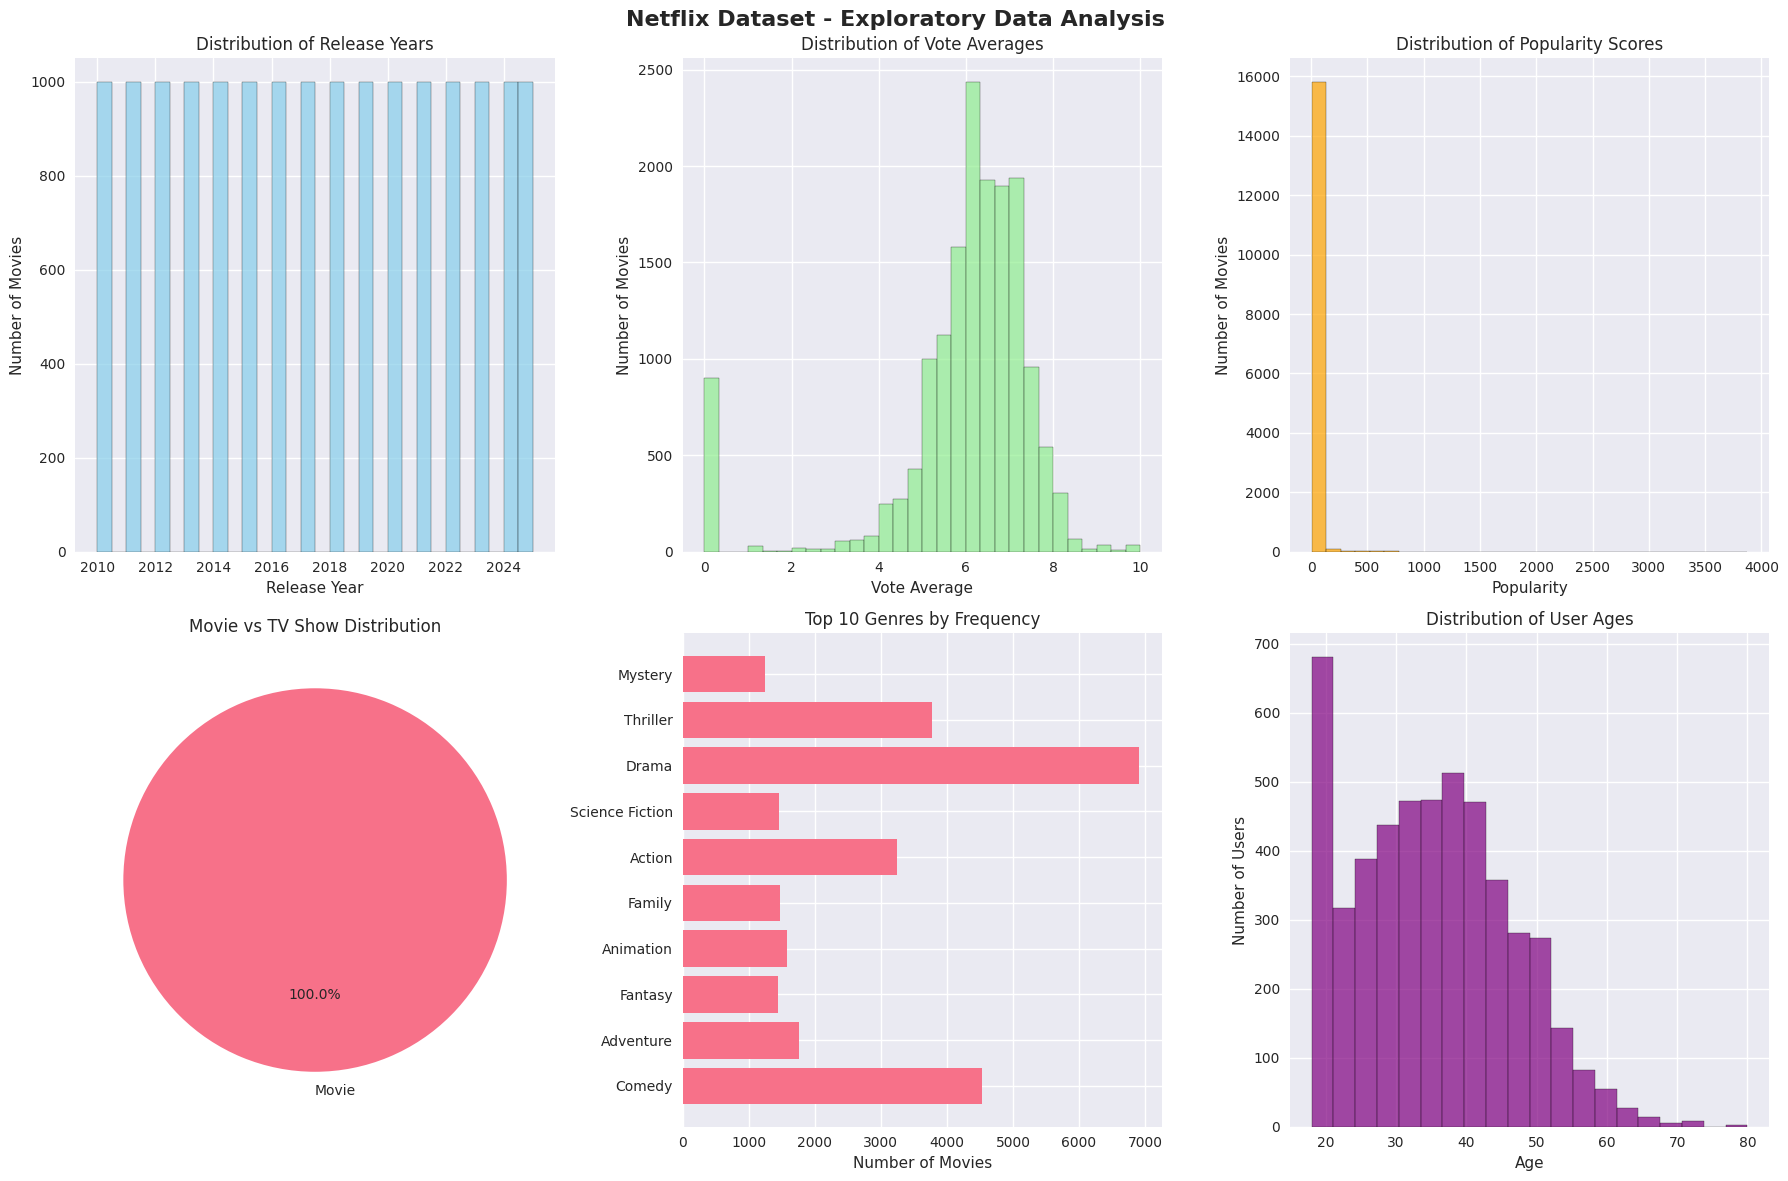



User Interaction Stats
Total interactions: 49,988
Like rate: 0.505
Average rating: 6.04
Average watch percentage: 45.5%

User engagement statistics:
       total_interactions  total_likes   like_rate  avg_watch_percentage  \
count         4999.000000  4999.000000  4999.00000           4999.000000   
mean             9.999600     5.045009     0.50581             45.584463   
std              3.158796     2.232167     0.16950             10.480529   
min              2.000000     0.000000     0.00000              8.775000   
25%              8.000000     3.000000     0.40000             38.600000   
50%             10.000000     5.000000     0.50000             45.321000   
75%             12.000000     6.000000     0.62500             52.371000   
max             22.000000    16.000000     1.00000             90.033000   

        avg_rating  
count  4999.000000  
mean      6.044078  
std       0.668683  
min       3.500000  
25%       5.612500  
50%       6.067000  
75%       6.48800

In [6]:
# Create visualizations for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Netflix Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Release year distribution
axes[0,0].hist(df_movies['release_year'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Release Years')
axes[0,0].set_xlabel('Release Year')
axes[0,0].set_ylabel('Number of Movies')

# 2. Vote average distribution
axes[0,1].hist(df_movies['vote_average'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Vote Averages')
axes[0,1].set_xlabel('Vote Average')
axes[0,1].set_ylabel('Number of Movies')

# 3. Popularity distribution
axes[0,2].hist(df_movies['popularity'].dropna(), bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Distribution of Popularity Scores')
axes[0,2].set_xlabel('Popularity')
axes[0,2].set_ylabel('Number of Movies')

# 4. Type distribution (Movie vs TV Show)
type_counts = df_movies['type'].value_counts()
axes[1,0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Movie vs TV Show Distribution')

# 5. Top genres
top_genres = pd.Series(genre_counts).head(10)
axes[1,1].barh(range(len(top_genres)), top_genres.values)
axes[1,1].set_yticks(range(len(top_genres)))
axes[1,1].set_yticklabels(top_genres.index)
axes[1,1].set_title('Top 10 Genres by Frequency')
axes[1,1].set_xlabel('Number of Movies')

# 6. User age distribution
axes[1,2].hist(df_users['age'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,2].set_title('Distribution of User Ages')
axes[1,2].set_xlabel('Age')
axes[1,2].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

# Interaction data analysis
print("\n" + "="*50)
print("\nUser Interaction Stats")

print(f"Total interactions: {len(df_interactions):,}")
print(f"Like rate: {df_interactions['liked'].mean():.3f}")
print(f"Average rating: {df_interactions['rating'].mean():.2f}")
print(f"Average watch percentage: {df_interactions['watch_percentage'].mean():.1f}%")

# User engagement metrics
user_engagement = df_interactions.groupby('user_id').agg({
    'liked': ['count', 'sum', 'mean'],
    'watch_percentage': 'mean',
    'rating': 'mean'
}).round(3)
user_engagement.columns = ['total_interactions', 'total_likes', 'like_rate', 'avg_watch_percentage', 'avg_rating']

print("\nUser engagement statistics:")
print(user_engagement.describe())

## 4. Data Preprocessing and Cleaning

In [7]:
# Data preprocessing and cleaning functions
def preprocess_movies_data(df):
    """Clean and preprocess the movies dataset"""
    df = df.copy()
    
    # Handle missing values
    print("Handling missing values...")
    
    # Fill missing ratings with median
    df['vote_average'].fillna(df['vote_average'].median(), inplace=True)
    df['vote_count'].fillna(0, inplace=True)
    
    # Fill missing popularity with median
    df['popularity'].fillna(df['popularity'].median(), inplace=True)
    
    # Fill missing budget and revenue with 0
    df['budget'].fillna(0, inplace=True)
    df['revenue'].fillna(0, inplace=True)
    
    # Fill missing release_year with median
    df['release_year'].fillna(df['release_year'].median(), inplace=True)
    
    # Handle missing categorical data
    df['director'].fillna('Unknown', inplace=True)
    df['cast'].fillna('Unknown', inplace=True)
    df['country'].fillna('Unknown', inplace=True)
    df['language'].fillna('en', inplace=True)
    df['genres'].fillna('Unknown', inplace=True)
    df['description'].fillna('No description', inplace=True)
    
    # Handle duration - extract numeric values
    df['duration_minutes'] = df['duration'].apply(lambda x: 
        int(str(x).replace(' min', '')) if pd.notna(x) and 'min' in str(x) else 
        (90 if pd.notna(x) and 'Season' in str(x) else 120))
    
    # Create binary features
    df['is_movie'] = (df['type'] == 'Movie').astype(int)
    df['has_budget'] = (df['budget'] > 0).astype(int)
    df['has_revenue'] = (df['revenue'] > 0).astype(int)
    
    # Create calculated features
    df['profit'] = df['revenue'] - df['budget']
    df['roi'] = np.where(df['budget'] > 0, df['profit'] / df['budget'], 0)
    
    # Age of movie (years since release)
    current_year = 2025
    df['movie_age'] = current_year - df['release_year']
    
    # Popularity rank
    df['popularity_rank'] = df['popularity'].rank(pct=True)
    
    # Rating categories
    df['rating_category'] = pd.cut(df['vote_average'], 
                                  bins=[0, 5, 7, 8, 10], 
                                  labels=['Poor', 'Average', 'Good', 'Excellent'])
    
    print(f"Movies dataset preprocessed. Shape: {df.shape}")
    return df

def preprocess_user_data(df):
    """Clean and preprocess the user dataset"""
    df = df.copy()
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100], 
                            labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Watch time categories
    df['watch_time_category'] = pd.cut(df['avg_daily_watch_time'], 
                                      bins=[0, 1, 2, 4, 10], 
                                      labels=['Light', 'Moderate', 'Heavy', 'Extreme'])
    
    # Account maturity
    df['account_maturity'] = pd.cut(df['account_age_months'], 
                                   bins=[0, 6, 12, 24, 60], 
                                   labels=['New', 'Growing', 'Established', 'Veteran'])
    
    # Number of preferred genres
    df['num_preferred_genres'] = df['preferred_genres'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
    
    print(f"User dataset preprocessed. Shape: {df.shape}")
    return df

# Apply preprocessing
df_movies_clean = preprocess_movies_data(df_movies)
df_users_clean = preprocess_user_data(df_users)

print("\nData preprocessing done")
print(f"Movies dataset: {df_movies_clean.shape}")
print(f"Users dataset: {df_users_clean.shape}")
print(f"Interactions dataset: {df_interactions.shape}")

Handling missing values...
Movies dataset preprocessed. Shape: (16000, 27)
User dataset preprocessed. Shape: (5000, 13)

Data preprocessing done
Movies dataset: (16000, 27)
Users dataset: (5000, 13)
Interactions dataset: (49988, 7)


## 5. Feature Engineering and Dataset Creation

In [8]:
# Feature Engineering: Create comprehensive features for ML modeling
def create_comprehensive_features(df_interactions, df_users_clean, df_movies_clean):
    """Create engineered features for machine learning"""
    
    # Merge all datasets
    df_full = df_interactions.merge(df_users_clean, on='user_id', how='left')
    df_full = df_full.merge(df_movies_clean, on='show_id', how='left')
    
    print(f"Full dataset shape: {df_full.shape}")
    
    # User-level features (calculated from interaction history)
    user_stats = df_interactions.groupby('user_id').agg({
        'rating': ['mean', 'std', 'count'],
        'liked': ['sum', 'mean'],
        'watch_percentage': 'mean',
        'minutes_watched': 'mean'
    }).round(3)
    
    user_stats.columns = ['user_avg_rating', 'user_rating_std', 'user_total_interactions',
                         'user_total_likes', 'user_like_rate', 'user_avg_watch_pct', 'user_avg_minutes']
    
    # Fill NaN values for std (users with only 1 interaction)
    user_stats['user_rating_std'].fillna(0, inplace=True)
    
    # Movie-level features (calculated from all interactions)
    movie_stats = df_interactions.groupby('show_id').agg({
        'rating': ['mean', 'std', 'count'],
        'liked': ['sum', 'mean'],
        'watch_percentage': 'mean'
    }).round(3)
    
    movie_stats.columns = ['movie_avg_rating', 'movie_rating_std', 'movie_total_interactions',
                          'movie_total_likes', 'movie_like_rate', 'movie_avg_watch_pct']
    
    movie_stats['movie_rating_std'].fillna(0, inplace=True)
    
    # Add user and movie stats to the full dataset
    df_full = df_full.merge(user_stats, on='user_id', how='left')
    df_full = df_full.merge(movie_stats, on='show_id', how='left')
    
    # Genre-based features
    # Create genre indicator variables for user preferences
    user_preferred_genres = df_users_clean.set_index('user_id')['preferred_genres'].str.get_dummies(sep=',')
    user_preferred_genres.columns = [f'user_likes_{col.lower().strip()}' for col in user_preferred_genres.columns]
    
    # Create movie genre indicators
    movie_genres = df_movies_clean.set_index('show_id')['genres'].str.get_dummies(sep=', ')
    movie_genres.columns = [f'movie_is_{col.lower().strip()}' for col in movie_genres.columns]
    
    # Add genre features
    df_full = df_full.merge(user_preferred_genres, left_on='user_id', right_index=True, how='left')
    df_full = df_full.merge(movie_genres, left_on='show_id', right_index=True, how='left')
    
    # Fill NaN values for genre features
    for col in user_preferred_genres.columns:
        if col in df_full.columns:
            df_full[col].fillna(0, inplace=True)
    
    for col in movie_genres.columns:
        if col in df_full.columns:
            df_full[col].fillna(0, inplace=True)
    
    # Interaction features (genre matching)
    # Calculate genre match score between user preferences and movie genres
    genre_match_scores = []
    
    for idx, row in df_full.iterrows():
        user_genres = [col.replace('user_likes_', '') for col in user_preferred_genres.columns if row.get(col, 0) == 1]
        movie_genres_list = [col.replace('movie_is_', '') for col in movie_genres.columns if row.get(col, 0) == 1]
        
        # Calculate match score
        if len(user_genres) > 0 and len(movie_genres_list) > 0:
            match_count = len(set(user_genres) & set(movie_genres_list))
            match_score = match_count / len(user_genres)  # Proportion of user's preferred genres that match
        else:
            match_score = 0
        
        genre_match_scores.append(match_score)
    
    df_full['genre_match_score'] = genre_match_scores
    
    # Additional engineered features
    df_full['user_movie_rating_diff'] = df_full['user_avg_rating'] - df_full['vote_average']
    df_full['popularity_vs_user_interactions'] = df_full['popularity'] / (df_full['user_total_interactions'] + 1)
    df_full['movie_popularity_rank_norm'] = df_full['popularity_rank']
    df_full['user_selectivity'] = 1 / (df_full['user_like_rate'] + 0.1)  # How selective the user is
    df_full['movie_appeal'] = df_full['movie_like_rate'] * df_full['vote_average']
    
    # Temporal features
    df_full['interaction_year'] = df_full['interaction_date'].dt.year
    df_full['interaction_month'] = df_full['interaction_date'].dt.month
    df_full['interaction_dayofweek'] = df_full['interaction_date'].dt.dayofweek
    df_full['movie_age_at_interaction'] = df_full['interaction_year'] - df_full['release_year']
    
    print(f"Dataset shape: {df_full.shape}")
    print(f"Total features: {len(df_full.columns)}")
    
    return df_full

# Create the comprehensive feature set
df_features = create_comprehensive_features(df_interactions, df_users_clean, df_movies_clean)

print("\nFeature sample:")
feature_columns = ['user_avg_rating', 'movie_like_rate', 'genre_match_score', 
                  'user_selectivity', 'movie_appeal', 'movie_age_at_interaction']
print(df_features[feature_columns].describe())

Full dataset shape: (49988, 45)


Dataset shape: (49988, 98)
Total features: 98

Feature sample:
       user_avg_rating  movie_like_rate  genre_match_score  user_selectivity  \
count     49988.000000     49988.000000       49988.000000      49988.000000   
mean          6.042172         0.504524           0.173838          1.817701   
std           0.631603         0.279774           0.292220          0.758583   
min           3.500000         0.000000           0.000000          0.909091   
25%           5.631000         0.333000           0.000000          1.398601   
50%           6.062000         0.500000           0.000000          1.666667   
75%           6.467000         0.667000           0.333333          2.000000   
max           8.350000         1.000000           1.000000         10.000000   

       movie_appeal  movie_age_at_interaction  
count  49988.000000              49988.000000  
mean       3.116368                  6.497379  
std        1.990939                  4.604277  
min        0.000000     

## 6. Data Validation and Train-Test Split

In [9]:
# Prepare data for machine learning
def prepare_ml_dataset(df_features):
    """Prepare the dataset for machine learning"""
    
    # Select features for modeling (exclude identifiers and target-related columns)
    exclude_columns = ['user_id', 'show_id', 'rating', 'liked', 'interaction_date',
                      'title', 'director', 'cast', 'country', 'date_added', 'description',
                      'type', 'genres', 'preferred_genres', 'language', 'gender', 'subscription_type',
                      'preferred_watch_time', 'age_group', 'watch_time_category', 'account_maturity',
                      'rating_category', 'duration']
    
    # Get feature columns
    feature_cols = [col for col in df_features.columns if col not in exclude_columns]
    
    # Prepare X (features) and y (target)
    X = df_features[feature_cols].copy()
    y = df_features['liked'].copy()
    
    # Handle any remaining missing values
    # For numerical columns, fill with median
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        X[col].fillna(X[col].median(), inplace=True)
    
    # For categorical columns, fill with mode or 'Unknown'
    categorical_columns = X.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown', inplace=True)
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution: {y.value_counts()}")
    print(f"Like rate: {y.mean():.3f}")
    
    return X, y, feature_cols

# Stratified train-test-validation split ensuring users appear in training set
def create_stratified_split(df_features, test_size=0.2, val_size=0.2, random_state=42):
    """Create stratified split ensuring no user cold-start problem"""
    
    # Ensure all users have at least one interaction in training set
    # Group by user and split at user level first
    user_groups = df_features.groupby('user_id').size().reset_index(name='interaction_count')
    
    # Users with many interactions can be split
    heavy_users = user_groups[user_groups['interaction_count'] >= 3]['user_id'].tolist()
    light_users = user_groups[user_groups['interaction_count'] < 3]['user_id'].tolist()
    
    # Split heavy users into train/test, light users all go to train
    train_users = light_users + list(np.random.choice(heavy_users, 
                                                      size=int(len(heavy_users) * (1-test_size)), 
                                                      replace=False))
    test_users = [u for u in heavy_users if u not in train_users]
    
    # Further split train users for validation
    val_users = list(np.random.choice(train_users, 
                                     size=int(len(train_users) * val_size), 
                                     replace=False))
    train_users = [u for u in train_users if u not in val_users]
    
    # Create splits
    train_idx = df_features['user_id'].isin(train_users)
    val_idx = df_features['user_id'].isin(val_users)
    test_idx = df_features['user_id'].isin(test_users)
    
    print(f"Train users: {len(train_users)}, Validation users: {len(val_users)}, Test users: {len(test_users)}")
    print(f"Train samples: {train_idx.sum()}, Validation samples: {val_idx.sum()}, Test samples: {test_idx.sum()}")
    
    return train_idx, val_idx, test_idx

# Prepare the data
X, y, feature_columns = prepare_ml_dataset(df_features)

# Create stratified splits
train_idx, val_idx, test_idx = create_stratified_split(df_features)

# Split the data
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nFinal dataset splits:")
print(f"Training: {X_train.shape[0]} samples, Like rate: {y_train.mean():.3f}")
print(f"Validation: {X_val.shape[0]} samples, Like rate: {y_val.mean():.3f}")  
print(f"Test: {X_test.shape[0]} samples, Like rate: {y_test.mean():.3f}")

print(f"\nTop 20 features:")
print(feature_columns[:20])

Features shape: (49988, 77)
Target distribution: liked
1    25220
0    24768
Name: count, dtype: int64
Like rate: 0.505
Train users: 3200, Validation users: 800, Test users: 999
Train samples: 32034, Validation samples: 7966, Test samples: 9988

Final dataset splits:
Training: 32034 samples, Like rate: 0.504
Validation: 7966 samples, Like rate: 0.508
Test: 9988 samples, Like rate: 0.503

Top 20 features:
['rating_x', 'minutes_watched', 'watch_percentage', 'age', 'country_x', 'avg_daily_watch_time', 'account_age_months', 'num_preferred_genres', 'country_y', 'release_year', 'rating_y', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue', 'duration_minutes', 'is_movie', 'has_budget', 'has_revenue']


## 7. Feature Selection and Preprocessing

In [10]:
# Feature selection and preprocessing pipeline
def create_preprocessing_pipeline(X_train, X_val, X_test, y_train):
    """Create preprocessing pipeline with feature selection"""
    
    # Scale numerical features
    scaler = StandardScaler()
    
    # Identify numerical columns
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns
    
    print(f"Numerical features: {len(numeric_columns)}")
    print(f"Categorical features: {len(categorical_columns)}")
    
    # Scale numerical features
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    if len(numeric_columns) > 0:
        X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
        X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
        X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    # Handle categorical features (if any)
    if len(categorical_columns) > 0:
        # Use Label Encoder for categorical features
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            # Fit on all unique values from train, val, and test
            all_values = pd.concat([X_train[col], X_val[col], X_test[col]]).unique()
            le.fit(all_values)
            
            X_train_scaled[col] = le.transform(X_train[col])
            X_val_scaled[col] = le.transform(X_val[col])
            X_test_scaled[col] = le.transform(X_test[col])
            
            label_encoders[col] = le
    
    print(f"Preprocessing completed. Feature shape: {X_train_scaled.shape}")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Feature selection using various methods
def perform_feature_selection(X_train, X_val, X_test, y_train, y_val, top_k=50):
    """Perform feature selection using multiple methods"""
    
    # Method 1: Statistical feature selection (SelectKBest)
    selector_stats = SelectKBest(score_func=f_classif, k=top_k)
    X_train_selected = selector_stats.fit_transform(X_train, y_train)
    X_val_selected = selector_stats.transform(X_val)
    X_test_selected = selector_stats.transform(X_test)
    
    selected_features_stats = X_train.columns[selector_stats.get_support()]
    print(f"Statistical selection: {len(selected_features_stats)} features")
    
    # Method 2: Random Forest feature importance
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features by importance
    selected_features_rf = feature_importance.head(top_k)['feature'].tolist()
    
    X_train_rf = X_train[selected_features_rf]
    X_val_rf = X_val[selected_features_rf]
    X_test_rf = X_test[selected_features_rf]
    
    print(f"Random Forest selection: {len(selected_features_rf)} features")
    
    # Method 3: Correlation-based selection
    correlation_matrix = X_train.corr().abs()
    
    # Find pairs of highly correlated features
    upper_tri = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    
    # Find features to drop (correlation > 0.95)
    high_corr_pairs = []
    for col in upper_tri.columns:
        high_corr_features = upper_tri[col][upper_tri[col] > 0.95].index.tolist()
        if high_corr_features:
            high_corr_pairs.extend([(col, feat, upper_tri[col][feat]) for feat in high_corr_features])
    
    # Remove highly correlated features
    features_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
    features_after_corr = [col for col in X_train.columns if col not in features_to_drop]
    
    X_train_corr = X_train[features_after_corr]
    X_val_corr = X_val[features_after_corr]
    X_test_corr = X_test[features_after_corr]
    
    print(f"After correlation filtering: {len(features_after_corr)} features")
    print(f"Removed {len(features_to_drop)} highly correlated features")
    
    # Return multiple feature sets for comparison
    return {
        'statistical': {
            'X_train': X_train_selected, 'X_val': X_val_selected, 'X_test': X_test_selected,
            'features': selected_features_stats.tolist()
        },
        'random_forest': {
            'X_train': X_train_rf, 'X_val': X_val_rf, 'X_test': X_test_rf,
            'features': selected_features_rf
        },
        'correlation_filtered': {
            'X_train': X_train_corr, 'X_val': X_val_corr, 'X_test': X_test_corr,
            'features': features_after_corr
        },
        'feature_importance': feature_importance
    }

# Apply preprocessing
X_train_scaled, X_val_scaled, X_test_scaled, scaler = create_preprocessing_pipeline(
    X_train, X_val, X_test, y_train)

# Perform feature selection
feature_sets = perform_feature_selection(X_train_scaled, X_val_scaled, X_test_scaled, 
                                        y_train, y_val, top_k=30)

print(f"\nTop 10 most important features (Random Forest):")
print(feature_sets['feature_importance'].head(10))

Numerical features: 75
Categorical features: 2
Preprocessing completed. Feature shape: (32034, 77)
Statistical selection: 30 features
Random Forest selection: 30 features
After correlation filtering: 70 features
Removed 7 highly correlated features

Top 10 most important features (Random Forest):
                feature  importance
0              rating_x    0.189568
35      movie_like_rate    0.105601
72         movie_appeal    0.085954
2      watch_percentage    0.061662
1       minutes_watched    0.059656
34    movie_total_likes    0.040058
31     movie_avg_rating    0.030914
28       user_like_rate    0.029967
71     user_selectivity    0.029939
36  movie_avg_watch_pct    0.021530


## 8. Model Building and Training

In [11]:
# Model building and training functions
def train_baseline_models(feature_sets, y_train, y_val):
    """Train baseline models on different feature sets"""
    
    models = {}
    results = {}
    
    # Define baseline models
    baseline_models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
    }
    
    print("Training baseline models on different feature sets...")
    print("="*60)
    
    for feature_set_name, feature_data in feature_sets.items():
        if feature_set_name == 'feature_importance':  # Skip the importance dataframe
            continue
            
        print(f"\n{feature_set_name.upper()} FEATURE SET ({len(feature_data['features'])} features)")
        print("-" * 50)
        
        X_train_fs = feature_data['X_train']
        X_val_fs = feature_data['X_val']
        
        for model_name, model in baseline_models.items():
            # Train the model
            start_time = pd.Timestamp.now()
            model.fit(X_train_fs, y_train)
            training_time = (pd.Timestamp.now() - start_time).total_seconds()
            
            # Predictions
            y_train_pred = model.predict(X_train_fs)
            y_val_pred = model.predict(X_val_fs)
            
            # Probabilities for ROC-AUC
            y_train_proba = model.predict_proba(X_train_fs)[:, 1]
            y_val_proba = model.predict_proba(X_val_fs)[:, 1]
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, y_train_pred)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            train_precision = precision_score(y_train, y_train_pred)
            val_precision = precision_score(y_val, y_val_pred)
            
            train_recall = recall_score(y_train, y_train_pred)
            val_recall = recall_score(y_val, y_val_pred)
            
            train_f1 = f1_score(y_train, y_train_pred)
            val_f1 = f1_score(y_val, y_val_pred)
            
            train_auc = roc_auc_score(y_train, y_train_proba)
            val_auc = roc_auc_score(y_val, y_val_proba)
            
            # Store results
            key = f"{model_name}_{feature_set_name}"
            models[key] = model
            results[key] = {
                'model_name': model_name,
                'feature_set': feature_set_name,
                'n_features': len(feature_data['features']),
                'training_time': training_time,
                'train_accuracy': train_acc,
                'val_accuracy': val_acc,
                'train_precision': train_precision,
                'val_precision': val_precision,
                'train_recall': train_recall,
                'val_recall': val_recall,
                'train_f1': train_f1,
                'val_f1': val_f1,
                'train_auc': train_auc,
                'val_auc': val_auc,
                'overfitting': train_acc - val_acc
            }
            
            print(f"{model_name:20} - Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
    
    return models, results

def create_results_dataframe(results):
    """Create a comprehensive results dataframe"""
    df_results = pd.DataFrame(results).T
    df_results = df_results.round(4)
    return df_results.sort_values('val_f1', ascending=False)

# Train baseline models
trained_models, model_results = train_baseline_models(feature_sets, y_train, y_val)

# Create results dataframe
results_df = create_results_dataframe(model_results)

print(f"\n{'='*80}")
print("MODEL PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(results_df[['model_name', 'feature_set', 'n_features', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_auc', 'overfitting']].head(10))

Training baseline models on different feature sets...

STATISTICAL FEATURE SET (30 features)
--------------------------------------------------
Logistic Regression  - Val Acc: 0.8933, Val F1: 0.8951, Val AUC: 0.9629
Random Forest        - Val Acc: 0.8826, Val F1: 0.8850, Val AUC: 0.9567
XGBoost              - Val Acc: 0.8968, Val F1: 0.8982, Val AUC: 0.9662

RANDOM_FOREST FEATURE SET (30 features)
--------------------------------------------------
Logistic Regression  - Val Acc: 0.8935, Val F1: 0.8953, Val AUC: 0.9628
Random Forest        - Val Acc: 0.8831, Val F1: 0.8856, Val AUC: 0.9566
XGBoost              - Val Acc: 0.8914, Val F1: 0.8927, Val AUC: 0.9651

CORRELATION_FILTERED FEATURE SET (70 features)
--------------------------------------------------
Logistic Regression  - Val Acc: 0.8937, Val F1: 0.8953, Val AUC: 0.9627
Random Forest        - Val Acc: 0.8784, Val F1: 0.8807, Val AUC: 0.9528
XGBoost              - Val Acc: 0.8903, Val F1: 0.8923, Val AUC: 0.9649

MODEL PERFORMANC

## 9. Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for best performing models
def hyperparameter_tuning(best_feature_set, y_train, y_val, cv_folds=3):
    """Perform hyperparameter tuning on the best performing models"""
    
    print("Performing hyperparameter tuning...")
    print(f"Using feature set: {best_feature_set}")
    
    X_train_best = feature_sets[best_feature_set]['X_train']
    X_val_best = feature_sets[best_feature_set]['X_val']
    
    # Combine train and validation for cross-validation
    X_combined = np.vstack([X_train_best, X_val_best])
    y_combined = np.hstack([y_train, y_val])
    
    tuned_models = {}
    tuning_results = {}
    
    # 1. Random Forest Hyperparameter Tuning
    print("\nTuning Random Forest...")
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_grid,
        n_iter=20,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    rf_random_search.fit(X_combined, y_combined)
    tuned_models['Random Forest'] = rf_random_search.best_estimator_
    tuning_results['Random Forest'] = {
        'best_params': rf_random_search.best_params_,
        'best_cv_score': rf_random_search.best_score_
    }
    print(f"Best RF CV Score: {rf_random_search.best_score_:.4f}")
    
    # 2. XGBoost Hyperparameter Tuning
    print("\nTuning XGBoost...")
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_random_search = RandomizedSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        xgb_param_grid,
        n_iter=20,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    xgb_random_search.fit(X_combined, y_combined)
    tuned_models['XGBoost'] = xgb_random_search.best_estimator_
    tuning_results['XGBoost'] = {
        'best_params': xgb_random_search.best_params_,
        'best_cv_score': xgb_random_search.best_score_
    }
    print(f"Best XGBoost CV Score: {xgb_random_search.best_score_:.4f}")
    
    # 3. Neural Network Hyperparameter Tuning
    print("\nTuning Neural Network...")
    mlp_param_grid = {
        'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
    
    mlp_random_search = RandomizedSearchCV(
        MLPClassifier(random_state=42, max_iter=500),
        mlp_param_grid,
        n_iter=15,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    mlp_random_search.fit(X_combined, y_combined)
    tuned_models['Neural Network'] = mlp_random_search.best_estimator_
    tuning_results['Neural Network'] = {
        'best_params': mlp_random_search.best_params_,
        'best_cv_score': mlp_random_search.best_score_
    }
    print(f"Best NN CV Score: {mlp_random_search.best_score_:.4f}")
    
    return tuned_models, tuning_results

# Find best feature set from baseline results
best_model_key = results_df.index[0]  # Best performing model
best_feature_set = results_df.loc[best_model_key, 'feature_set']

print(f"Best performing baseline model: {results_df.loc[best_model_key, 'model_name']}")
print(f"Best feature set: {best_feature_set}")

# Perform hyperparameter tuning
tuned_models, tuning_results = hyperparameter_tuning(best_feature_set, y_train, y_val)

print(f"\n{'='*60}")
print("HYPERPARAMETER TUNING RESULTS")
print(f"{'='*60}")
for model_name, results in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV Score: {results['best_cv_score']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")

Best performing baseline model: XGBoost
Best feature set: statistical
Performing hyperparameter tuning...
Using feature set: statistical

Tuning Random Forest...


## 10. Final Model Evaluation and Testing

FINAL MODEL EVALUATION ON TEST SET

Evaluating Random Forest...


  Accuracy:  0.8855
  Precision: 0.8814
  Recall:    0.8923
  F1-Score:  0.8868
  ROC-AUC:   0.9611
  Confusion Matrix:
    TN:  4363  FP:   603
    FN:   541  TP:  4481

Evaluating XGBoost...
  Accuracy:  0.8992
  Precision: 0.8970
  Recall:    0.9032
  F1-Score:  0.9001
  ROC-AUC:   0.9708
  Confusion Matrix:
    TN:  4445  FP:   521
    FN:   486  TP:  4536

Evaluating Neural Network...
  Accuracy:  0.8993
  Precision: 0.9019
  Recall:    0.8973
  F1-Score:  0.8996
  ROC-AUC:   0.9700
  Confusion Matrix:
    TN:  4476  FP:   490
    FN:   516  TP:  4506


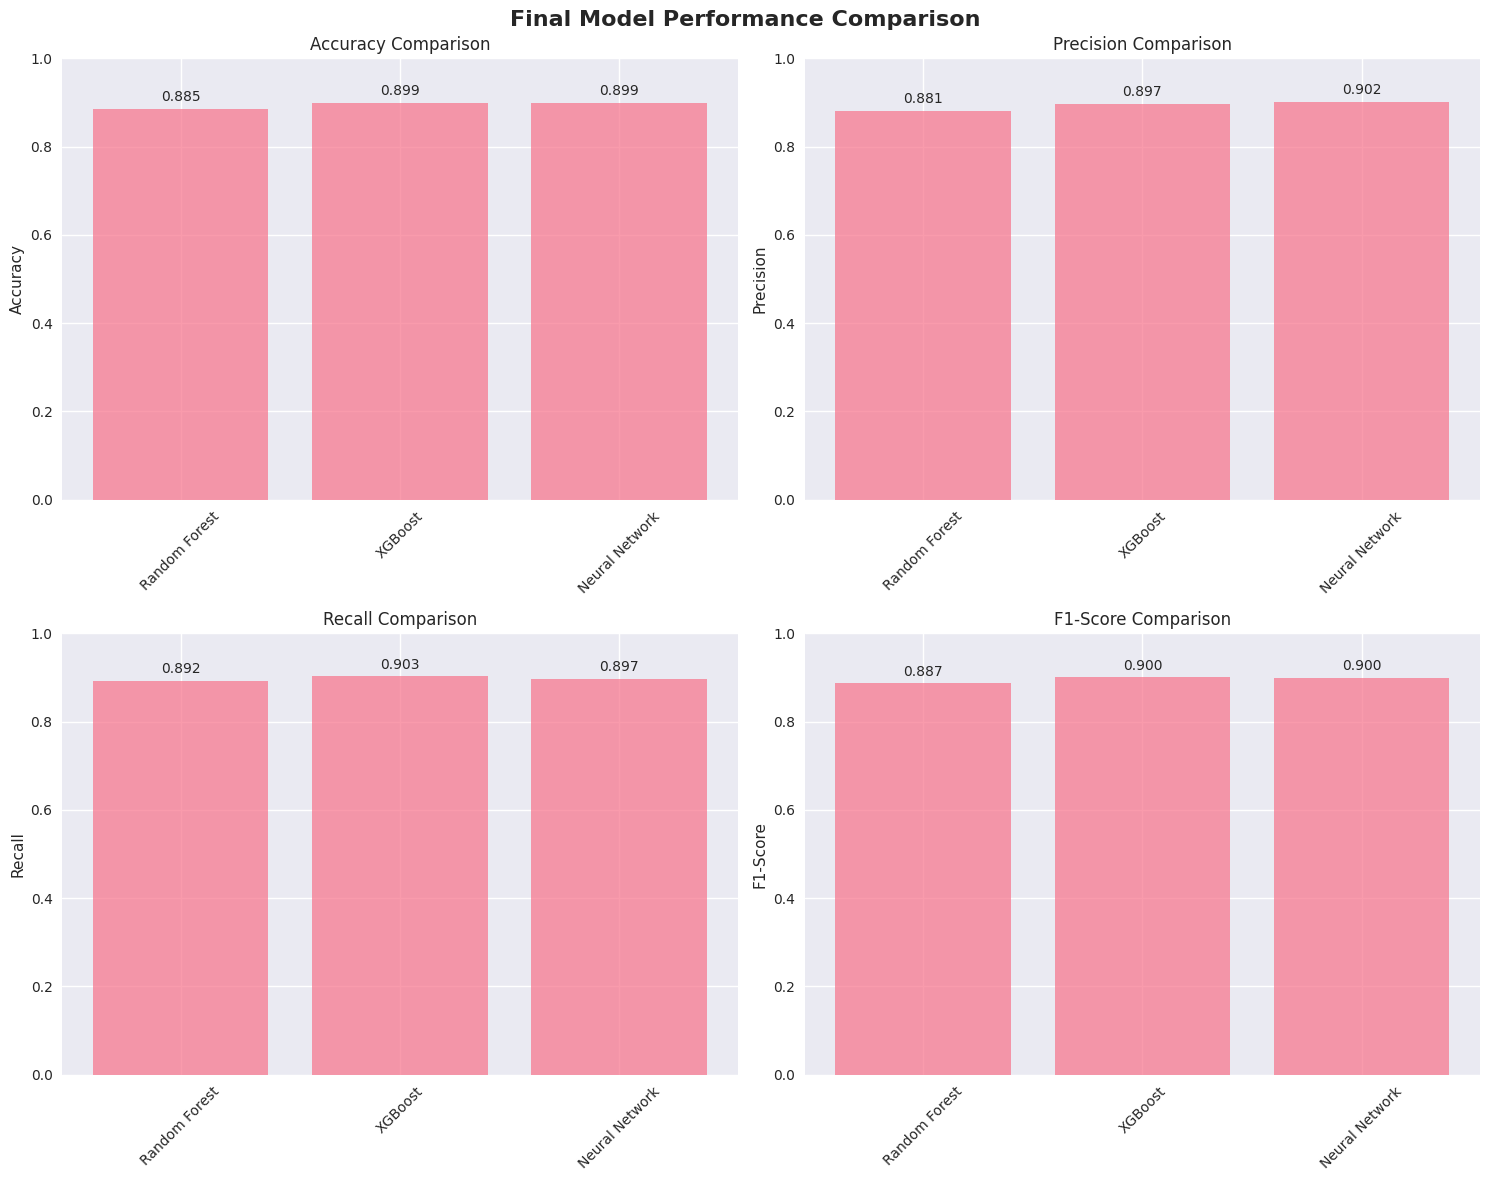


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
----------------------------------------
                        Random Forest  XGBoost  average
rating_x                       0.2610   0.2470   0.2540
movie_like_rate                0.1199   0.2256   0.1727
minutes_watched                0.0600   0.1577   0.1089
watch_percentage               0.0679   0.0734   0.0707
movie_appeal                   0.0971   0.0099   0.0535
movie_total_likes              0.0484   0.0423   0.0453
user_like_rate                 0.0320   0.0551   0.0435
movie_avg_rating               0.0365   0.0381   0.0373
movie_avg_watch_pct            0.0259   0.0218   0.0239
user_avg_rating                0.0203   0.0202   0.0203
movie_rating_std               0.0229   0.0149   0.0189
user_selectivity               0.0340   0.0000   0.0170
user_avg_watch_pct             0.0157   0.0122   0.0140
user_rating_std                0.0171   0.0082   0.0126
user_movie_rating_diff         0.0165   0.0082   0.0124


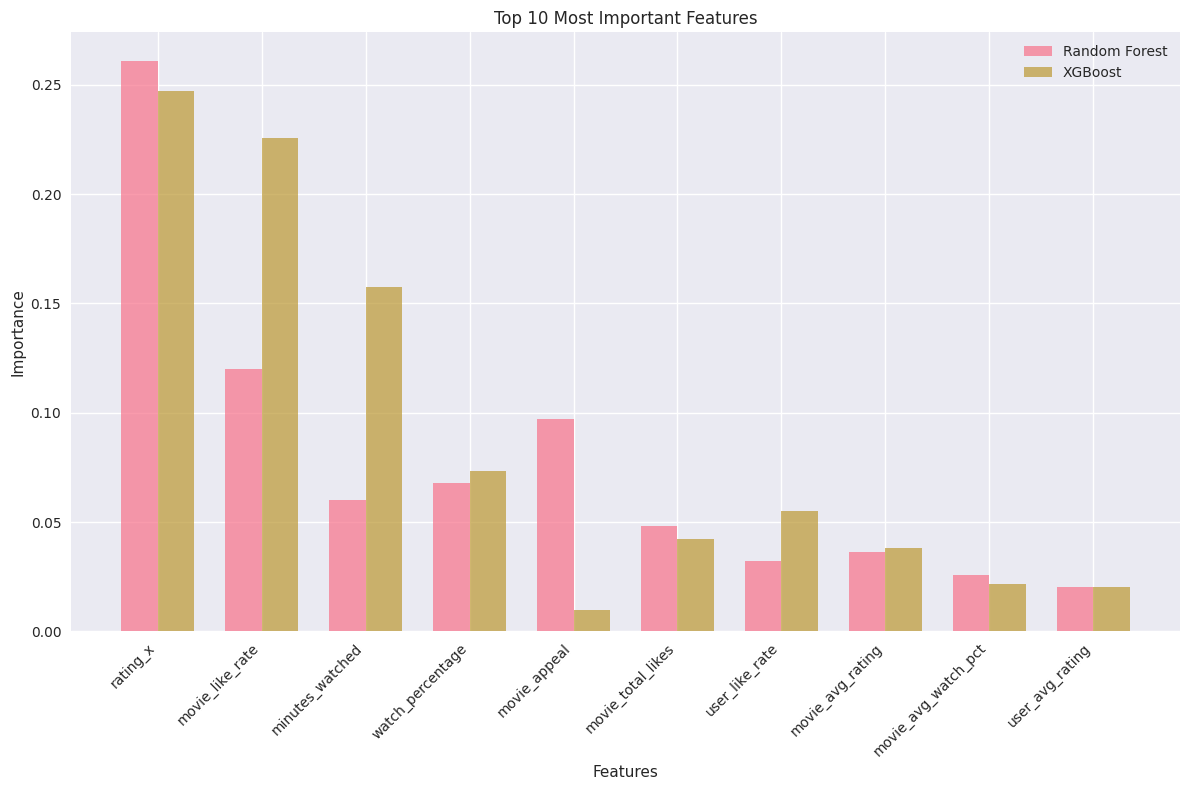


FINAL MODEL COMPARISON
                accuracy  precision  recall      f1     auc
Random Forest     0.8855     0.8814  0.8923  0.8868  0.9611
XGBoost           0.8992     0.8970  0.9032  0.9001  0.9708
Neural Network    0.8993     0.9019  0.8973  0.8996  0.9700


In [ ]:
# Final model evaluation on test set
def evaluate_final_models(tuned_models, feature_sets, best_feature_set, y_test):
    """Evaluate tuned models on test set"""
    
    print("FINAL MODEL EVALUATION ON TEST SET")
    print("="*50)
    
    X_test_best = feature_sets[best_feature_set]['X_test']
    
    final_results = {}
    
    for model_name, model in tuned_models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Predictions
        y_test_pred = model.predict(X_test_best)
        y_test_proba = model.predict_proba(X_test_best)[:, 1]
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        final_results[model_name] = {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc
        }
        
        print(f"  Accuracy:  {test_accuracy:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall:    {test_recall:.4f}")
        print(f"  F1-Score:  {test_f1:.4f}")
        print(f"  ROC-AUC:   {test_auc:.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"  Confusion Matrix:")
        print(f"    TN: {cm[0,0]:5d}  FP: {cm[0,1]:5d}")
        print(f"    FN: {cm[1,0]:5d}  TP: {cm[1,1]:5d}")
    
    return final_results

def create_comparison_visualization(final_results):
    """Create visualization comparing final model performance"""
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(final_results).T
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Final Model Performance Comparison', fontsize=16, fontweight='bold')
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        bars = ax.bar(comparison_df.index, comparison_df[metric], alpha=0.7)
        ax.set_title(f'{title} Comparison')
        ax.set_ylabel(title)
        ax.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')
        
        # Rotate x-axis labels if needed
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

def analyze_feature_importance(tuned_models, feature_sets, best_feature_set):
    """Analyze feature importance from the best model"""
    
    print("\nFEATURE IMPORTANCE ANALYSIS")
    print("="*40)
    
    features = feature_sets[best_feature_set]['features']
    
    # Get feature importance from Random Forest and XGBoost
    importance_data = {}
    
    if 'Random Forest' in tuned_models:
        rf_model = tuned_models['Random Forest']
        if hasattr(rf_model, 'feature_importances_'):
            importance_data['Random Forest'] = rf_model.feature_importances_
    
    if 'XGBoost' in tuned_models:
        xgb_model = tuned_models['XGBoost']
        if hasattr(xgb_model, 'feature_importances_'):
            importance_data['XGBoost'] = xgb_model.feature_importances_
    
    # Create feature importance DataFrame
    if importance_data:
        importance_df = pd.DataFrame(importance_data, index=features)
        importance_df['average'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('average', ascending=False)
        
        print("\nTop 15 Most Important Features:")
        print("-" * 40)
        print(importance_df.head(15).round(4))
        
        # Visualize top features
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(10)
        
        if len(importance_data) > 1:
            x = np.arange(len(top_features))
            width = 0.35
            
            plt.bar(x - width/2, top_features[list(importance_data.keys())[0]], 
                   width, label=list(importance_data.keys())[0], alpha=0.7)
            plt.bar(x + width/2, top_features[list(importance_data.keys())[1]], 
                   width, label=list(importance_data.keys())[1], alpha=0.7)
        else:
            plt.bar(range(len(top_features)), top_features.iloc[:, 0], alpha=0.7)
        
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right')
        if len(importance_data) > 1:
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("No feature importance available for the models.")
        return None

# Run final evaluation
final_results = evaluate_final_models(tuned_models, feature_sets, best_feature_set, y_test)

# Create comparison visualization
comparison_df = create_comparison_visualization(final_results)

# Analyze feature importance
feature_importance_df = analyze_feature_importance(tuned_models, feature_sets, best_feature_set)

print(f"\n{'='*60}")
print("FINAL MODEL COMPARISON")
print(f"{'='*60}")
print(comparison_df.round(4))